In [1]:
# import networkx as nx
# import osmnx as ox
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from fiona.crs import from_epsg
import os
from scipy import spatial
import shutil
from math import sin, cos, sqrt, atan2, radians
import random
import shapely
import networkx as nx
import osmnx as ox

# Download pipeline
1. download panoids
2. filter the panoid by sample locations
3. selective download images
- after or in 2015

In [ ]:
# Project Tracking: https://docs.google.com/spreadsheets/d/1o5gFmZPUoDwrrbfE6M26uJF3HnEZll02ivnOxP6K6Xw/edit?usp=sharing

In [2]:
boundfolder = "/lustre1/g/geog_pyloo/05_timemachine/GSV/bound"
metafolder = "/lustre1/g/geog_pyloo/05_timemachine/GSV"
# metafolder = "/group/geog_pyloo/08_GSV/"
GSVROOT = "/lustre1/g/geog_pyloo/05_timemachine/GSV/gsv_rgb"
# GSVROOT = "/group/geog_pyloo/08_GSV/data/gsv_rgb"
os.listdir(metafolder)

['gsv_rgb']

In [5]:
serviceaccount = "../../google_drive_personal.json"
import gspread
# from oauth2client.service_account import ServiceAccountCredentials
gc = gspread.service_account(filename = serviceaccount)
def read_url(url, SHEET_NAME):
    SHEET_ID = url.split('/')[5]
    spreadsheet = gc.open_by_key(SHEET_ID)
    worksheet = spreadsheet.worksheet(SHEET_NAME)
    rows = worksheet.get_all_records()
    df_spread = pd.DataFrame(rows)
    return df_spread, worksheet

url = "https://docs.google.com/spreadsheets/d/1o5gFmZPUoDwrrbfE6M26uJF3HnEZll02ivnOxP6K6Xw/edit?usp=sharing"
SHEETNAME = "select_city_classifier"
city_meta, other_worksheet = read_url( url, SHEETNAME)
city_meta = city_meta[city_meta['City']!=''].reset_index(drop = True)
city_country_name = dict(zip(city_meta['City'], city_meta['Country']))
city_meta.set_index('City', inplace = True)
city_meta
# import json
# with open('city_country_name.json', 'w') as fp:
#     json.dump(city_country_name, fp, indent=4)

,Country,Continent,State/Province,center_lat,center_lng,label,num_panoid,GSV Downloaded,Drink & Drive Imprison,Annual Raindrop,left,bottom,right,top,urban_pop,pop source,country_clean,county_ls
City,,,,,,,,,,,,,,,,,,
Buenos Aires,Argentina,South America,Buenos Aires,-34.599589,-58.380564,18,606938,2365132,,,-58.531449,-34.705181,-58.335352,-34.526573,3120612,2022,Argentina,[]
Sydney,Australia,Australia,New South Wales,-33.870453,151.208755,112,3411953,1413083,,,150.264995,-34.171875,151.341577,-33.378928,5312000,2019,Australia,[]
Vienna,Austria,Europe,Vienna,48.208166,16.371864,122,1166126,319435,,,16.182084,48.118545,16.577249,48.320919,1897000,2019,Austria,[]
Saidpur,Bangladesh,Asia,Rangpur Division,25.778031,88.897626,102,4442,12721,,,88.851607,25.740739,88.995211,25.863039,24338,2011,Bangladesh,[]
Rajshahi,Bangladesh,Asia,Rajshahi,24.374650,88.600367,95,240371,186022,,,88.017099,23.812853,89.754481,25.270728,984000,2024,Bangladesh,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
New York,United States,North America,New York,40.748459,-73.988593,83,2449048,757884,,,-74.255283,40.496237,-73.700473,40.912690,8336000,2022,United States of America,"[New York, Kings, Queens, Bronx, Richmond]"
Los Angeles,United States,North America,California,34.052235,-118.243683,65,2312065,940535,,,-118.668150,33.846503,-118.155441,34.335035,3822000,2022,United States of America,[Los Angeles]
Houston,United States,North America,Texas,29.760400,-95.369800,43,4574777,2261113,,,-95.784863,29.400217,-94.955259,30.120746,2303000,2022,United States of America,[Harris]


# 1. Get pts to send to get the panoid

In [14]:
highway = ['tertiary', 'secondary','primary','motorway', 'trunk']
def get_folder(cityabbr):
    generalgsv = f'{GSVROOT}/{cityabbr}'
    imgfolder = os.path.join(generalgsv, 'img_rgb')
    metafolder = os.path.join(generalgsv, 'gsvmeta')
    if not os.path.exists(metafolder):
        os.makedirs(metafolder)
    if not os.path.exists(imgfolder):
        os.makedirs(imgfolder)
    return imgfolder, generalgsv, metafolder

def convert_3D_2D(geometry):
    from shapely.geometry import Polygon, MultiPolygon
    '''
    Takes a GeoSeries of 3D Multi/Polygons (has_z) and returns a list of 2D Multi/Polygons
    '''
    new_geo = []
    for p in geometry:
        if p.has_z:
            if p.geom_type == 'Polygon':
                lines = [xy[:2] for xy in list(p.exterior.coords)]
                new_p = Polygon(lines)
                new_geo.append(new_p)
            elif p.geom_type == 'MultiPolygon':
                new_multi_p = []
                for ap in p:
                    lines = [xy[:2] for xy in list(ap.exterior.coords)]
                    new_p = Polygon(lines)
                    new_multi_p.append(new_p)
                new_geo.append(MultiPolygon(new_multi_p))
        else:
            new_geo.append(p)
    return new_geo

def cleanosmid(x):
    if type(x)==list:
        x = [str(t) for t in x]
        return "_".join(x)
    else:
        return str(x)
    
def get_city_bound(city):
    bound = gpd.read_file(os.path.join(boundfolder, boundfile[city]))
    bound['city'] = city
    bound = bound.to_crs("EPSG:4326")
    # flatten the geometry by removing z axis
    bound['geometry'] = convert_3D_2D(bound['geometry'])
    bound['geometry'] = bound['geometry'].simplify(tolerance=0.001, preserve_topology=True)
    bound = bound.to_crs("EPSG:4326")
    bound = bound.dissolve(by= 'city')
    return bound

def get_road(bound, generalgsv):
    G = ox.graph_from_polygon(bound['geometry'].values[0], 
                            network_type='all', 
                            simplify=True, 
                            retain_all=False, 
                            truncate_by_edge=False, 
                            clean_periphery=None, 
                            custom_filter=None)

    gdf_edges = ox.graph_to_gdfs(G, nodes=False, edges=True, node_geometry=False, fill_edge_geometry=True)
    g_proj = gdf_edges.copy()
    g_proj['osmid'] = g_proj['osmid'].apply(lambda x: cleanosmid(x))
    g_proj['name'] = g_proj['name'].apply(lambda x: cleanosmid(x))
    g_proj = g_proj.reset_index()

    roadfolder = os.path.join(generalgsv, 'road')
    if not os.path.exists(roadfolder):
        os.makedirs(roadfolder)
    
    g_proj['newID'] = g_proj.index
    g_proj['newID'] = g_proj['osmid']+'_'+ g_proj['newID'].astype(str)
    g_proj = g_proj.to_crs("EPSG:3857")
    g_proj['length_meter'] = g_proj.geometry.length
    # g_proj[['u','v','osmid','name','geometry','length','length_meter','newID']].to_file(os.path.join(generalgsv, 'road','osm.geojson'), 
    #                                                             driver = 'GeoJSON')
    return g_proj

def get_road_place(city_country, generalgsv):
    G = ox.graph_from_place(city_country, 
                            network_type='all', 
                            simplify=True, 
                            retain_all=False, 
                            truncate_by_edge=False, 
                            clean_periphery=None, 
                            custom_filter=None)

    gdf_edges = ox.graph_to_gdfs(G, nodes=False, edges=True, node_geometry=False, fill_edge_geometry=True)
    g_proj = gdf_edges.copy()
    g_proj['osmid'] = g_proj['osmid'].apply(lambda x: cleanosmid(x))
    g_proj['name'] = g_proj['name'].apply(lambda x: cleanosmid(x))
    g_proj = g_proj.reset_index()

    roadfolder = os.path.join(generalgsv, 'road')
    if not os.path.exists(roadfolder):
        os.makedirs(roadfolder)
    
    g_proj['newID'] = g_proj.index
    g_proj['newID'] = g_proj['osmid']+'_'+ g_proj['newID'].astype(str)
    g_proj = g_proj.to_crs("EPSG:3857")
    g_proj['length_meter'] = g_proj.geometry.length
    g_proj['highway_str']= g_proj['highway'].apply(lambda x: "".join(x))
    g_proj['is_highway'] = g_proj['highway_str'].apply(lambda x: any([i in x for i in highway]))
    # g_proj[['u','v','osmid','name','geometry','length','length_meter','newID','highway_str', 'is_highway']].to_file(os.path.join(generalgsv, 'road','osm.geojson'), 
    #                                                             driver = 'GeoJSON')
    return g_proj

class BoundingBox(object):
    def __init__(self, *args, **kwargs):
        self.lat_min = None
        self.lon_min = None
        self.lat_max = None
        self.lon_max = None
    def get_bounding_box(latitude_in_degrees, longitude_in_degrees, half_side_in_km):
        import math
        assert half_side_in_km > 0
        assert latitude_in_degrees >= -90.0 and latitude_in_degrees  <= 90.0
        assert longitude_in_degrees >= -180.0 and longitude_in_degrees <= 180.0

        lat = math.radians(latitude_in_degrees)
        lon = math.radians(longitude_in_degrees)

        radius  = 6371
        # Radius of the parallel at given latitude
        parallel_radius = radius*math.cos(lat)

        lat_min = lat - half_side_in_km/radius
        lat_max = lat + half_side_in_km/radius
        lon_min = lon - half_side_in_km/parallel_radius
        lon_max = lon + half_side_in_km/parallel_radius
        rad2deg = math.degrees

        box = BoundingBox()
        box.lat_min = rad2deg(lat_min)
        box.lon_min = rad2deg(lon_min)
        box.lat_max = rad2deg(lat_max)
        box.lon_max = rad2deg(lon_max)

        return (box)



def get_road_bbox(bbox, generalgsv):
    G = ox.graph_from_bbox(bbox[0], bbox[1], bbox[2], bbox[3],
                            network_type='all', 
                            simplify=True, 
                            retain_all=False, 
                            truncate_by_edge=False, 
                            clean_periphery=None, 
                            custom_filter=None)
    gdf_edges = ox.graph_to_gdfs(G, nodes=False, edges=True, node_geometry=False, fill_edge_geometry=True)
    g_proj = gdf_edges.copy()
    g_proj['osmid'] = g_proj['osmid'].apply(lambda x: cleanosmid(x))
    g_proj['name'] = g_proj['name'].apply(lambda x: cleanosmid(x))
    g_proj = g_proj.reset_index()

    roadfolder = os.path.join(generalgsv, 'road')
    if not os.path.exists(roadfolder):
        os.makedirs(roadfolder)
    
    g_proj['newID'] = g_proj.index
    g_proj['newID'] = g_proj['osmid']+'_'+ g_proj['newID'].astype(str)
    g_proj = g_proj.to_crs("EPSG:3857")
    g_proj['length_meter'] = g_proj.geometry.length
    g_proj['highway_str']= g_proj['highway'].apply(lambda x: "".join(x))
    g_proj['is_highway'] = g_proj['highway_str'].apply(lambda x: any([i in x for i in highway]))
    g_proj[['u','v','osmid','name','geometry','length','length_meter','newID','highway_str', 'is_highway']].to_file(os.path.join(generalgsv, 'road','osm.geojson'), 
                                                                driver = 'GeoJSON')
    return g_proj

def get_pt(road, metafolder):
    pointList=[]
    roadlist =[]

    interval = 60
    sec = interval/2

    for i,length in enumerate(road.length_meter):
        if length<=interval:
            pointList.append(road.geometry[i].interpolate(0.5, normalized = True))
            roadlist.append(road.at[i,"newID"])
        else:
            for dist in np.arange(sec/length,1-sec/length, interval/length):
                pointList.append(road.geometry[i].interpolate(dist, normalized = True)) 
                roadlist.append(road.at[i,"newID"])
            
    pointDF = gpd.GeoDataFrame(pd.DataFrame(dict(geometry = pointList, newID=roadlist)))

    pointDF.crs = from_epsg(3857)
    pointDF = pointDF.to_crs('EPSG:4326')

    # pointDF.to_file('../output/shp/reqPoints.shp')
    pointDF['lat'] = pointDF.geometry.y
    pointDF['lon'] = pointDF.geometry.x

    pointDF = pointDF.drop_duplicates(subset=['lon','lat']).reset_index(drop=True)

    pointDF = pointDF.assign(id = pointDF.index)
    pointDF.to_pickle(os.path.join(metafolder, 'sentPt.p'))
    # pointDF.sample(0.1).plot(figsize=(15,15), markersize=0.5)
    return pointDF

def get_bbox(bound):
    # change the bound to a simple bounding box
    bbox = bound['geometry'].values[0].bounds
    # construct a rectangle from the bounding box
    rect = shapely.geometry.box(*bbox)
    # convert the rectangle to a polygon
    poly = shapely.geometry.Polygon(rect.exterior)
    # convert the polygon to a geodataframe
    poly_gdf = gpd.GeoDataFrame([poly], columns=['geometry'])
    return poly_gdf

In [9]:
# check which city already finished roadnetwork downloading
def check_city():
    citylist = []
    remain = []
    for city in city_country_name.keys():
        citylower = city.lower().replace(" ","")
        generalgsv = f'{GSVROOT}/{citylower}'
        if os.path.exists(os.path.join(generalgsv, 'gsvmeta','sentPt.p')):
            citylist.append(city)
        else:
            remain.append(city)
            
    return citylist, remain


In [15]:
city = 'Mumbai'
boundfolder = "/group/geog_pyloo/08_GSV/data/_raw/r_boundary_osm"
citylower = city.lower().replace(" ","")
imgfolder, generalgsv, metafolder = get_folder(citylower)
# center_lat, center_lon = city_meta.loc[city, ['center_lat','center_lng']]
# road = gpd.read_file(f"{GSVROOT}/{citylower}/road/osm.geojson")
bound = gpd.read_file(os.path.join(boundfolder, f"{citylower}.geojson"))
# sentpt = pd.read_pickle(f"/lustre1/g/geog_pyloo/05_timemachine/GSV/gsv_rgb/{citylower}/gsvmeta/sentPt.p")
road = get_road(bound, generalgsv)

/home/yuanzf/anaconda3/envs/geo38/lib/python3.8/site-packages/osmnx/graph.py:478: UserWarning: the graph-level street_count attribute will likely be inaccurate when you set clean_periphery=False
  warnings.warn(msg)


In [17]:
pointDF = get_pt(road, metafolder)

/home/yuanzf/anaconda3/envs/geo38/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [19]:
pointDF.head()

,geometry,newID,lat,lon,id
0,POINT (72.96092 19.05927),84017620_0,19.059273,72.960922,0
1,POINT (72.96040 19.05915),84017620_0,19.059149,72.960399,1
2,POINT (72.95988 19.05903),84017620_0,19.059025,72.959877,2
3,POINT (72.81641 18.90602),38756487_1,18.906021,72.816413,3
4,POINT (72.81614 18.90595),39492674_2,18.905946,72.816139,4


<AxesSubplot:>

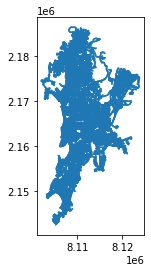

In [16]:
road.plot() # too small need redownload

In [29]:
# image folder:

def run_all(city):
    cityabbr = city.replace(" ", "").lower()
    # Set up folders
    imgfolder, generalgsv, metafolder = get_folder(cityabbr)
    city_country_str = city + ", " + city_country_name[city]
    road = get_road_place(city_country_str, generalgsv)
    print("Number of road rows downloaded: ", road.shape[0])
    # road.plot(linewidth = 0.2, 
    #         figsize=(15,15))
    pointDF = get_pt(road, metafolder)
    print("Number of points downloaded: ", pointDF.shape[0])
    


In [6]:
city = 'Singapore'
citylower = city.lower().replace(" ","")
city_country_str = city + ", " + city_country_name[city]
imgfolder, generalgsv, metafolder = get_folder(citylower)
road = get_road_place(city_country_str, generalgsv)



In [10]:
road.head()

,u,v,key,osmid,oneway,lanes,ref,name,highway,maxspeed,...,access,tunnel,junction,width,est_width,area,newID,length_meter,highway_str,is_highway
0,25451929,6749812859,0,49961799_718881456_741164883_754786742_173767676,True,5,ECP,East Coast Parkway,motorway,70,...,NaN,NaN,NaN,NaN,NaN,NaN,49961799_718881456_741164883_754786742_1737676...,766.083407,motorway,True
1,25455287,1637003462,0,150829205,True,1,NaN,Kallang Paya Lebar Expressway,motorway_link,50,...,NaN,NaN,NaN,NaN,NaN,NaN,150829205_1,629.920011,motorway_link,True
2,25455287,2521018789,0,633215386_74607482_635109319,True,"[3, 2]",ECP,East Coast Parkway,motorway,90,...,NaN,NaN,NaN,NaN,NaN,NaN,633215386_74607482_635109319_2,653.472737,motorway,True
3,26777521,7885679552,0,559564482,False,2,NaN,Cuscaden Road,residential,50,...,NaN,NaN,NaN,NaN,NaN,NaN,559564482_3,17.410993,residential,False
4,26777521,172424179,0,481674707_654734557_633179143,True,2,NaN,Grange Road,primary,40,...,NaN,NaN,NaN,NaN,NaN,NaN,481674707_654734557_633179143_4,114.152849,primary,True


In [26]:
road['is_highway'] = road['highway_str'].apply(lambda x: any([i in x for i in highway]))
road.groupby('is_highway').size()

is_highway
False    243416
True      16589
dtype: int64

<Axes: >

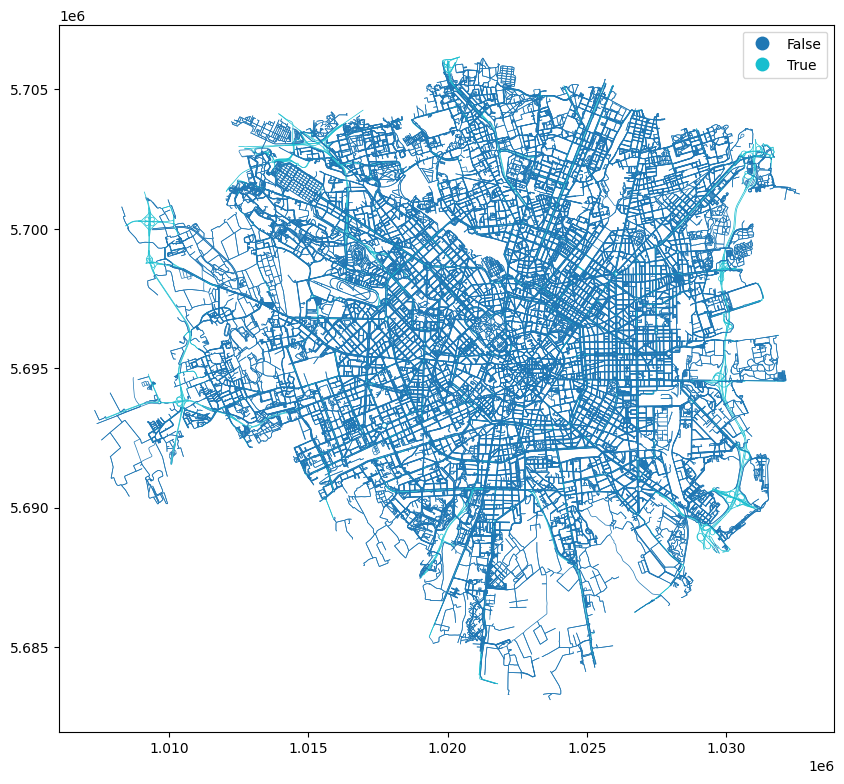

In [27]:
road.plot(column = 'is_highway', figsize = (10,10), legend = True, linewidth = 0.5)

In [11]:
from tqdm import tqdm
finished, remain = check_city()
print("Number of cities remained to be processed: ", len(remain))
for city in tqdm(remain):
    print(city)
    try:
        run_all(city)
    except Exception as error:
    # handle the exception
        print("An exception occurred:", error) # An exception occurred: division by zero

Number of cities remained to be processed:  94


  0%|          | 0/94 [00:00<?, ?it/s]

Lahore
An exception occurred: Nominatim could not geocode query 'Lahore, Pakistan' to a geometry of type (Multi)Polygon
Osaka


  2%|▏         | 2/94 [00:00<00:26,  3.45it/s]

An exception occurred: Nominatim could not geocode query 'Osaka, Japan' to a geometry of type (Multi)Polygon
Cordoba
Number of road rows downloaded:  116562


/tmp/jobtmp-yuanzf-1598270/ipykernel_1386653/3315329807.py:12: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  pointDF = get_pt(road, metafolder)
  3%|▎         | 3/94 [01:42<1:04:39, 42.63s/it]

Number of points downloaded:  182409
Vienna
Number of road rows downloaded:  362665


/tmp/jobtmp-yuanzf-1598270/ipykernel_1386653/3315329807.py:12: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  pointDF = get_pt(road, metafolder)
  4%|▍         | 4/94 [04:35<2:16:46, 91.18s/it]

Number of points downloaded:  398613
Baku
Number of road rows downloaded:  92552


/tmp/jobtmp-yuanzf-1598270/ipykernel_1386653/3315329807.py:12: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  pointDF = get_pt(road, metafolder)
  5%|▌         | 5/94 [05:20<1:51:35, 75.23s/it]

Number of points downloaded:  113036
Rajshahi
Number of road rows downloaded:  62631


/tmp/jobtmp-yuanzf-1598270/ipykernel_1386653/3315329807.py:12: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  pointDF = get_pt(road, metafolder)
  6%|▋         | 6/94 [07:29<2:16:17, 92.93s/it]

Number of points downloaded:  444317
Saidpur
Number of road rows downloaded:  4362


/tmp/jobtmp-yuanzf-1598270/ipykernel_1386653/3315329807.py:12: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  pointDF = get_pt(road, metafolder)
  7%|▋         | 7/94 [07:41<1:37:05, 66.96s/it]

Number of points downloaded:  13061
Antwerp
Number of road rows downloaded:  69812


/tmp/jobtmp-yuanzf-1598270/ipykernel_1386653/3315329807.py:12: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  pointDF = get_pt(road, metafolder)
  9%|▊         | 8/94 [08:36<1:30:52, 63.40s/it]

Number of points downloaded:  112750
Cochabamba
Number of road rows downloaded:  101649


/tmp/jobtmp-yuanzf-1598270/ipykernel_1386653/3315329807.py:12: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  pointDF = get_pt(road, metafolder)
 10%|▉         | 9/94 [09:32<1:26:30, 61.06s/it]

Number of points downloaded:  112445
Belo Horizonte
Number of road rows downloaded:  119304


/tmp/jobtmp-yuanzf-1598270/ipykernel_1386653/3315329807.py:12: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  pointDF = get_pt(road, metafolder)
 11%|█         | 10/94 [11:15<1:43:15, 73.76s/it]

Number of points downloaded:  155248
Curitiba
Number of road rows downloaded:  173876


/tmp/jobtmp-yuanzf-1598270/ipykernel_1386653/3315329807.py:12: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  pointDF = get_pt(road, metafolder)
 12%|█▏        | 11/94 [13:48<2:15:32, 97.99s/it]

Number of points downloaded:  203868
Florianopolis
Number of road rows downloaded:  57967


/tmp/jobtmp-yuanzf-1598270/ipykernel_1386653/3315329807.py:12: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  pointDF = get_pt(road, metafolder)
 13%|█▎        | 12/94 [14:30<1:50:46, 81.06s/it]

Number of points downloaded:  87952
Ilheus
Number of road rows downloaded:  13888


/tmp/jobtmp-yuanzf-1598270/ipykernel_1386653/3315329807.py:12: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  pointDF = get_pt(road, metafolder)
 14%|█▍        | 13/94 [14:53<1:25:41, 63.47s/it]

Number of points downloaded:  55052
Jequie
Number of road rows downloaded:  18147


/tmp/jobtmp-yuanzf-1598270/ipykernel_1386653/3315329807.py:12: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  pointDF = get_pt(road, metafolder)
 15%|█▍        | 14/94 [15:35<1:15:49, 56.87s/it]

Number of points downloaded:  54302
Palmas
Number of road rows downloaded:  42575


/tmp/jobtmp-yuanzf-1598270/ipykernel_1386653/3315329807.py:12: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  pointDF = get_pt(road, metafolder)
 16%|█▌        | 15/94 [16:14<1:07:53, 51.57s/it]

Number of points downloaded:  107057
Ribeirao Preto
Number of road rows downloaded:  66961


/tmp/jobtmp-yuanzf-1598270/ipykernel_1386653/3315329807.py:12: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  pointDF = get_pt(road, metafolder)
 17%|█▋        | 16/94 [16:55<1:02:48, 48.31s/it]

Number of points downloaded:  116625
Montreal
Number of road rows downloaded:  460242


/tmp/jobtmp-yuanzf-1598270/ipykernel_1386653/3315329807.py:12: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  pointDF = get_pt(road, metafolder)
 18%|█▊        | 17/94 [22:30<2:52:55, 134.75s/it]

Number of points downloaded:  468664
Victoria
Number of road rows downloaded:  16796


/tmp/jobtmp-yuanzf-1598270/ipykernel_1386653/3315329807.py:12: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  pointDF = get_pt(road, metafolder)
 19%|█▉        | 18/94 [22:50<2:06:54, 100.20s/it]

Number of points downloaded:  20230
Santiago
Number of road rows downloaded:  14147


/tmp/jobtmp-yuanzf-1598270/ipykernel_1386653/3315329807.py:12: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  pointDF = get_pt(road, metafolder)
 20%|██        | 19/94 [23:10<1:35:01, 76.02s/it] 

Number of points downloaded:  14603
Valledupar
Number of road rows downloaded:  29643


/tmp/jobtmp-yuanzf-1598270/ipykernel_1386653/3315329807.py:12: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  pointDF = get_pt(road, metafolder)
 21%|██▏       | 20/94 [23:50<1:20:19, 65.12s/it]

Number of points downloaded:  83576
Quito
Number of road rows downloaded:  286488


/tmp/jobtmp-yuanzf-1598270/ipykernel_1386653/3315329807.py:12: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  pointDF = get_pt(road, metafolder)


Number of points downloaded:  426721


 22%|██▏       | 21/94 [28:31<2:38:12, 130.03s/it]

San Salvador
Number of road rows downloaded:  23266


/tmp/jobtmp-yuanzf-1598270/ipykernel_1386653/3315329807.py:12: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  pointDF = get_pt(road, metafolder)
 23%|██▎       | 22/94 [29:15<2:04:54, 104.08s/it]

Number of points downloaded:  25603
Suva


 24%|██▍       | 23/94 [29:16<1:26:50, 73.39s/it] 

An exception occurred: Nominatim could not geocode query 'Suva, Fiji' to a geometry of type (Multi)Polygon
Le Mans
Number of road rows downloaded:  42437


/tmp/jobtmp-yuanzf-1598270/ipykernel_1386653/3315329807.py:12: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  pointDF = get_pt(road, metafolder)
 26%|██▌       | 24/94 [29:54<1:13:05, 62.65s/it]

Number of points downloaded:  48033
Thessaloniki
Number of road rows downloaded:  204084


/tmp/jobtmp-yuanzf-1598270/ipykernel_1386653/3315329807.py:12: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  pointDF = get_pt(road, metafolder)
 27%|██▋       | 25/94 [37:09<3:20:25, 174.28s/it]

Number of points downloaded:  629235
Guatemala City
Number of road rows downloaded:  64268


/tmp/jobtmp-yuanzf-1598270/ipykernel_1386653/3315329807.py:12: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  pointDF = get_pt(road, metafolder)
 28%|██▊       | 26/94 [38:00<2:35:39, 137.35s/it]

Number of points downloaded:  72457
Budapest
Number of road rows downloaded:  289579


/tmp/jobtmp-yuanzf-1598270/ipykernel_1386653/3315329807.py:12: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  pointDF = get_pt(road, metafolder)
 29%|██▊       | 27/94 [45:43<4:22:21, 234.95s/it]

Number of points downloaded:  390900
Ahmedabad


 30%|██▉       | 28/94 [45:45<3:01:52, 165.35s/it]

An exception occurred: Nominatim could not geocode query 'Ahmedabad, India' to a geometry of type (Multi)Polygon
Belgaum


 31%|███       | 29/94 [45:47<2:06:00, 116.32s/it]

An exception occurred: Nominatim could not geocode query 'Belgaum, India' to a geometry of type (Multi)Polygon
Coimbatore


 32%|███▏      | 30/94 [45:49<1:27:26, 81.98s/it] 

An exception occurred: Nominatim could not geocode query 'Coimbatore, India' to a geometry of type (Multi)Polygon
Hindupur
Number of road rows downloaded:  2903


/tmp/jobtmp-yuanzf-1598270/ipykernel_1386653/3315329807.py:12: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  pointDF = get_pt(road, metafolder)
 33%|███▎      | 31/94 [46:32<1:13:49, 70.31s/it]

Number of points downloaded:  7683
Jaipur
Number of road rows downloaded:  63771


/tmp/jobtmp-yuanzf-1598270/ipykernel_1386653/3315329807.py:12: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  pointDF = get_pt(road, metafolder)
 34%|███▍      | 32/94 [56:17<3:51:58, 224.49s/it]

Number of points downloaded:  277354
Jalna
Number of road rows downloaded:  54742


/tmp/jobtmp-yuanzf-1598270/ipykernel_1386653/3315329807.py:12: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  pointDF = get_pt(road, metafolder)
 35%|███▌      | 33/94 [1:02:14<4:28:39, 264.25s/it]

Number of points downloaded:  256017
Kanpur
Number of road rows downloaded:  181103


/tmp/jobtmp-yuanzf-1598270/ipykernel_1386653/3315329807.py:12: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  pointDF = get_pt(road, metafolder)


Number of points downloaded:  235114


 36%|███▌      | 34/94 [1:06:48<4:27:20, 267.35s/it]

Kozhikode
Number of road rows downloaded:  44323


/tmp/jobtmp-yuanzf-1598270/ipykernel_1386653/3315329807.py:12: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  pointDF = get_pt(road, metafolder)
 37%|███▋      | 35/94 [1:07:45<3:20:40, 204.08s/it]

Number of points downloaded:  94119
Malegaon
Number of road rows downloaded:  60861


/tmp/jobtmp-yuanzf-1598270/ipykernel_1386653/3315329807.py:12: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  pointDF = get_pt(road, metafolder)
 38%|███▊      | 36/94 [1:08:37<2:33:13, 158.51s/it]

Number of points downloaded:  156474
Parbhani
Number of road rows downloaded:  54285


/tmp/jobtmp-yuanzf-1598270/ipykernel_1386653/3315329807.py:12: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  pointDF = get_pt(road, metafolder)
 39%|███▉      | 37/94 [1:09:54<2:07:22, 134.07s/it]

Number of points downloaded:  187710
Pune
Number of road rows downloaded:  106583


/tmp/jobtmp-yuanzf-1598270/ipykernel_1386653/3315329807.py:12: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  pointDF = get_pt(road, metafolder)
 40%|████      | 38/94 [1:10:49<1:42:57, 110.32s/it]

Number of points downloaded:  121012
Singrauli


 41%|████▏     | 39/94 [1:10:54<1:12:09, 78.72s/it] 

An exception occurred: 'name'
Sitapur
Number of road rows downloaded:  54175


/tmp/jobtmp-yuanzf-1598270/ipykernel_1386653/3315329807.py:12: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  pointDF = get_pt(road, metafolder)
 43%|████▎     | 40/94 [1:12:07<1:09:19, 77.03s/it]

Number of points downloaded:  114341
Vijayawada
Number of road rows downloaded:  7839


/tmp/jobtmp-yuanzf-1598270/ipykernel_1386653/3315329807.py:12: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  pointDF = get_pt(road, metafolder)
 44%|████▎     | 41/94 [1:12:17<50:16, 56.91s/it]  

Number of points downloaded:  12809
Cirebon
Number of road rows downloaded:  25295


/tmp/jobtmp-yuanzf-1598270/ipykernel_1386653/3315329807.py:12: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  pointDF = get_pt(road, metafolder)
 45%|████▍     | 42/94 [1:12:44<41:36, 48.01s/it]

Number of points downloaded:  20640
Medan
Number of road rows downloaded:  141481


/tmp/jobtmp-yuanzf-1598270/ipykernel_1386653/3315329807.py:12: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  pointDF = get_pt(road, metafolder)
 46%|████▌     | 43/94 [1:15:04<1:04:22, 75.74s/it]

Number of points downloaded:  127670
Palembang
Number of road rows downloaded:  132345


/tmp/jobtmp-yuanzf-1598270/ipykernel_1386653/3315329807.py:12: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  pointDF = get_pt(road, metafolder)
 47%|████▋     | 44/94 [1:16:43<1:08:41, 82.44s/it]

Number of points downloaded:  118598
Parepare
Number of road rows downloaded:  12692


/tmp/jobtmp-yuanzf-1598270/ipykernel_1386653/3315329807.py:12: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  pointDF = get_pt(road, metafolder)
 48%|████▊     | 45/94 [1:16:57<50:45, 62.15s/it]  

Number of points downloaded:  13624
Pematangtiantar


 49%|████▉     | 46/94 [1:16:59<35:14, 44.05s/it]

An exception occurred: Nominatim geocoder returned 0 results for query 'Pematangtiantar, Indonesia'
Tel Aviv
Number of road rows downloaded:  49627


/tmp/jobtmp-yuanzf-1598270/ipykernel_1386653/3315329807.py:12: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  pointDF = get_pt(road, metafolder)
 50%|█████     | 47/94 [1:17:37<33:01, 42.16s/it]

Number of points downloaded:  47680
Palermo
Number of road rows downloaded:  34676


/tmp/jobtmp-yuanzf-1598270/ipykernel_1386653/3315329807.py:12: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  pointDF = get_pt(road, metafolder)
 51%|█████     | 48/94 [1:18:14<31:04, 40.54s/it]

Number of points downloaded:  56856
Fukuoka
Number of road rows downloaded:  940677


/tmp/jobtmp-yuanzf-1598270/ipykernel_1386653/3315329807.py:12: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  pointDF = get_pt(road, metafolder)
 52%|█████▏    | 49/94 [1:28:16<2:36:48, 209.08s/it]

Number of points downloaded:  1659114
Okayama
Number of road rows downloaded:  558304


/tmp/jobtmp-yuanzf-1598270/ipykernel_1386653/3315329807.py:12: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  pointDF = get_pt(road, metafolder)
 53%|█████▎    | 50/94 [1:35:23<3:21:20, 274.56s/it]

Number of points downloaded:  1393526
Yamaguchi
Number of road rows downloaded:  371087


/tmp/jobtmp-yuanzf-1598270/ipykernel_1386653/3315329807.py:12: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  pointDF = get_pt(road, metafolder)
 54%|█████▍    | 51/94 [1:41:15<3:33:19, 297.67s/it]

Number of points downloaded:  1034736
Shymkent
Number of road rows downloaded:  67759


/tmp/jobtmp-yuanzf-1598270/ipykernel_1386653/3315329807.py:12: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  pointDF = get_pt(road, metafolder)
 55%|█████▌    | 52/94 [1:41:57<2:34:41, 220.99s/it]

Number of points downloaded:  181888
Nakuru
Number of road rows downloaded:  20178


/tmp/jobtmp-yuanzf-1598270/ipykernel_1386653/3315329807.py:12: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  pointDF = get_pt(road, metafolder)
 56%|█████▋    | 53/94 [1:42:11<1:48:28, 158.74s/it]

Number of points downloaded:  34359
Busan


 57%|█████▋    | 54/94 [1:42:12<1:14:25, 111.65s/it]

An exception occurred: Nominatim geocoder returned 0 results for query 'Busan, Korea Rep.'
Cheonan


 59%|█████▊    | 55/94 [1:42:14<51:09, 78.70s/it]   

An exception occurred: Nominatim geocoder returned 0 results for query 'Cheonan, Korea Rep.'
Gwangju


 60%|█████▉    | 56/94 [1:42:16<35:13, 55.63s/it]

An exception occurred: Nominatim geocoder returned 0 results for query 'Gwangju, Korea Rep.'
Jinju


 61%|██████    | 57/94 [1:42:18<24:20, 39.46s/it]

An exception occurred: Nominatim geocoder returned 0 results for query 'Jinju, Korea Rep.'
Kaunas
Number of road rows downloaded:  100977


/tmp/jobtmp-yuanzf-1598270/ipykernel_1386653/3315329807.py:12: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  pointDF = get_pt(road, metafolder)
 62%|██████▏   | 58/94 [1:43:20<27:51, 46.42s/it]

Number of points downloaded:  134579
Ipoh


 63%|██████▎   | 59/94 [1:43:22<19:17, 33.08s/it]

An exception occurred: Nominatim could not geocode query 'Ipoh, Malaysia' to a geometry of type (Multi)Polygon
Rawang


 64%|██████▍   | 60/94 [1:43:27<13:50, 24.43s/it]

An exception occurred: Found no graph nodes within the requested polygon
Culiacan
Number of road rows downloaded:  124375


/tmp/jobtmp-yuanzf-1598270/ipykernel_1386653/3315329807.py:12: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  pointDF = get_pt(road, metafolder)
 65%|██████▍   | 61/94 [1:44:55<23:58, 43.59s/it]

Number of points downloaded:  266826
Guadalajara
Number of road rows downloaded:  74737


/tmp/jobtmp-yuanzf-1598270/ipykernel_1386653/3315329807.py:12: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  pointDF = get_pt(road, metafolder)
 66%|██████▌   | 62/94 [1:45:34<22:29, 42.18s/it]

Number of points downloaded:  79477
Reynosa
Number of road rows downloaded:  83822


/tmp/jobtmp-yuanzf-1598270/ipykernel_1386653/3315329807.py:12: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  pointDF = get_pt(road, metafolder)
 67%|██████▋   | 63/94 [1:46:23<22:51, 44.23s/it]

Number of points downloaded:  176263
Tijuana


 68%|██████▊   | 64/94 [1:46:25<15:48, 31.62s/it]

An exception occurred: Nominatim could not geocode query 'Tijuana, Mexico' to a geometry of type (Multi)Polygon
Pokhara
Number of road rows downloaded:  30315


/tmp/jobtmp-yuanzf-1598270/ipykernel_1386653/3315329807.py:12: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  pointDF = get_pt(road, metafolder)
 69%|██████▉   | 65/94 [1:47:00<15:50, 32.79s/it]

Number of points downloaded:  82191
Zwolle
Number of road rows downloaded:  56326


/tmp/jobtmp-yuanzf-1598270/ipykernel_1386653/3315329807.py:12: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  pointDF = get_pt(road, metafolder)
 70%|███████   | 66/94 [1:47:39<16:04, 34.44s/it]

Number of points downloaded:  73604
Auckland
Number of road rows downloaded:  487411


/tmp/jobtmp-yuanzf-1598270/ipykernel_1386653/3315329807.py:12: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  pointDF = get_pt(road, metafolder)
 71%|███████▏  | 67/94 [1:52:46<52:22, 116.40s/it]

Number of points downloaded:  738919
Gombe
Number of road rows downloaded:  97221


/tmp/jobtmp-yuanzf-1598270/ipykernel_1386653/3315329807.py:12: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  pointDF = get_pt(road, metafolder)
 72%|███████▏  | 68/94 [1:55:04<53:12, 122.78s/it]

Number of points downloaded:  368700
Ibadan


 73%|███████▎  | 69/94 [1:55:06<36:02, 86.50s/it] 

An exception occurred: Nominatim could not geocode query 'Ibadan, Nigeria' to a geometry of type (Multi)Polygon
Bacolod
Number of road rows downloaded:  45681


/tmp/jobtmp-yuanzf-1598270/ipykernel_1386653/3315329807.py:12: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  pointDF = get_pt(road, metafolder)
 74%|███████▍  | 70/94 [1:55:41<28:27, 71.14s/it]

Number of points downloaded:  56152
Cebu City
Number of road rows downloaded:  34064


/tmp/jobtmp-yuanzf-1598270/ipykernel_1386653/3315329807.py:12: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  pointDF = get_pt(road, metafolder)
 76%|███████▌  | 71/94 [1:56:07<22:06, 57.66s/it]

Number of points downloaded:  43652
Manila
Number of road rows downloaded:  31453


/tmp/jobtmp-yuanzf-1598270/ipykernel_1386653/3315329807.py:12: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  pointDF = get_pt(road, metafolder)
 77%|███████▋  | 72/94 [1:57:10<21:40, 59.12s/it]

Number of points downloaded:  28452
Warsaw
Number of road rows downloaded:  779938


/tmp/jobtmp-yuanzf-1598270/ipykernel_1386653/3315329807.py:12: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  pointDF = get_pt(road, metafolder)
 78%|███████▊  | 73/94 [2:02:36<48:43, 139.22s/it]

Number of points downloaded:  725313
Astrakhan
Number of road rows downloaded:  40089


/tmp/jobtmp-yuanzf-1598270/ipykernel_1386653/3315329807.py:12: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  pointDF = get_pt(road, metafolder)
 79%|███████▊  | 74/94 [2:03:08<35:40, 107.04s/it]

Number of points downloaded:  77401
Berezniki
Number of road rows downloaded:  27836


/tmp/jobtmp-yuanzf-1598270/ipykernel_1386653/3315329807.py:12: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  pointDF = get_pt(road, metafolder)
 80%|███████▉  | 75/94 [2:03:25<25:20, 80.03s/it] 

Number of points downloaded:  76778
Dzerzhinsk
Number of road rows downloaded:  29232


/tmp/jobtmp-yuanzf-1598270/ipykernel_1386653/3315329807.py:12: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  pointDF = get_pt(road, metafolder)
 81%|████████  | 76/94 [2:03:44<18:32, 61.82s/it]

Number of points downloaded:  88535
Saint Petersburg
Number of road rows downloaded:  1113444


/tmp/jobtmp-yuanzf-1598270/ipykernel_1386653/3315329807.py:12: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  pointDF = get_pt(road, metafolder)
 82%|████████▏ | 77/94 [2:11:17<50:42, 178.98s/it]

Number of points downloaded:  1420685
Tyumen
Number of road rows downloaded:  126515


/tmp/jobtmp-yuanzf-1598270/ipykernel_1386653/3315329807.py:12: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  pointDF = get_pt(road, metafolder)
 83%|████████▎ | 78/94 [2:12:17<38:13, 143.34s/it]

Number of points downloaded:  275839
Kigali
Number of road rows downloaded:  70823


/tmp/jobtmp-yuanzf-1598270/ipykernel_1386653/3315329807.py:12: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  pointDF = get_pt(road, metafolder)
 84%|████████▍ | 79/94 [2:13:10<29:02, 116.13s/it]

Number of points downloaded:  144160
Riyadh


/lustre1/u/yuanzf/anaconda3/envs/geo311/lib/python3.11/site-packages/osmnx/_overpass.py:211: UserWarning: This area is 180 times your configured Overpass max query area size. It will automatically be divided up into multiple sub-queries accordingly. This may take a long time.
  multi_poly_proj = utils_geo._consolidate_subdivide_geometry(poly_proj)


Number of road rows downloaded:  776569


/tmp/jobtmp-yuanzf-1598270/ipykernel_1386653/3315329807.py:12: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  pointDF = get_pt(road, metafolder)
 85%|████████▌ | 80/94 [2:27:09<1:17:44, 333.19s/it]

Number of points downloaded:  3006401
Belgrade
Number of road rows downloaded:  145501


/tmp/jobtmp-yuanzf-1598270/ipykernel_1386653/3315329807.py:12: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  pointDF = get_pt(road, metafolder)
 86%|████████▌ | 81/94 [2:28:37<56:14, 259.57s/it]  

Number of points downloaded:  198284
Port Elizabeth


 87%|████████▋ | 82/94 [2:28:39<36:26, 182.24s/it]

An exception occurred: Nominatim could not geocode query 'Port Elizabeth, South Africa' to a geometry of type (Multi)Polygon
Lausanne
Number of road rows downloaded:  41051


/tmp/jobtmp-yuanzf-1598270/ipykernel_1386653/3315329807.py:12: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  pointDF = get_pt(road, metafolder)
 88%|████████▊ | 83/94 [2:29:06<24:52, 135.72s/it]

Number of points downloaded:  37976
Rovno
Number of road rows downloaded:  25083


/tmp/jobtmp-yuanzf-1598270/ipykernel_1386653/3315329807.py:12: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  pointDF = get_pt(road, metafolder)
 89%|████████▉ | 84/94 [2:29:21<16:36, 99.63s/it] 

Number of points downloaded:  37816
Manchester
Number of road rows downloaded:  112792


/tmp/jobtmp-yuanzf-1598270/ipykernel_1386653/3315329807.py:12: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  pointDF = get_pt(road, metafolder)
 90%|█████████ | 85/94 [2:30:26<13:20, 89.00s/it]

Number of points downloaded:  128568
Sheffield
Number of road rows downloaded:  144881


/tmp/jobtmp-yuanzf-1598270/ipykernel_1386653/3315329807.py:12: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  pointDF = get_pt(road, metafolder)
 91%|█████████▏| 86/94 [2:31:54<11:51, 88.95s/it]

Number of points downloaded:  215455
Cleveland
Number of road rows downloaded:  91045


/tmp/jobtmp-yuanzf-1598270/ipykernel_1386653/3315329807.py:12: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  pointDF = get_pt(road, metafolder)
 93%|█████████▎| 87/94 [2:32:50<09:12, 78.94s/it]

Number of points downloaded:  128585
Gainesville, FL
Number of road rows downloaded:  86569


/tmp/jobtmp-yuanzf-1598270/ipykernel_1386653/3315329807.py:12: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  pointDF = get_pt(road, metafolder)
 94%|█████████▎| 88/94 [2:33:57<07:32, 75.45s/it]

Number of points downloaded:  82682
Killeen
Number of road rows downloaded:  31678


/tmp/jobtmp-yuanzf-1598270/ipykernel_1386653/3315329807.py:12: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  pointDF = get_pt(road, metafolder)
 95%|█████████▍| 89/94 [2:34:19<04:56, 59.36s/it]

Number of points downloaded:  44533
Minneapolis
Number of road rows downloaded:  200448


/tmp/jobtmp-yuanzf-1598270/ipykernel_1386653/3315329807.py:12: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  pointDF = get_pt(road, metafolder)
 96%|█████████▌| 90/94 [2:35:47<04:32, 68.06s/it]

Number of points downloaded:  227689
Modesto
Number of road rows downloaded:  43548


/tmp/jobtmp-yuanzf-1598270/ipykernel_1386653/3315329807.py:12: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  pointDF = get_pt(road, metafolder)
 97%|█████████▋| 91/94 [2:36:13<02:46, 55.44s/it]

Number of points downloaded:  58305
Portland, OR
Number of road rows downloaded:  188565


/tmp/jobtmp-yuanzf-1598270/ipykernel_1386653/3315329807.py:12: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  pointDF = get_pt(road, metafolder)
 98%|█████████▊| 92/94 [2:38:12<02:29, 74.51s/it]

Number of points downloaded:  243785
Raleigh
Number of road rows downloaded:  264765


/tmp/jobtmp-yuanzf-1598270/ipykernel_1386653/3315329807.py:12: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  pointDF = get_pt(road, metafolder)
 99%|█████████▉| 93/94 [2:40:37<01:35, 95.64s/it]

Number of points downloaded:  274610
Toledo
Number of road rows downloaded:  107205


/tmp/jobtmp-yuanzf-1598270/ipykernel_1386653/3315329807.py:12: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  pointDF = get_pt(road, metafolder)
100%|██████████| 94/94 [2:41:30<00:00, 103.09s/it]

Number of points downloaded:  145001


# 1. Use the point DF to get all panoid as of today

In [ ]:
./Reqeust_GSV_panoid.py
./Request_GSV_panoid_pl.py

In [14]:
exceptions = ['Lahore', 'Osaka']
cityls = [x for x in remain if not x in exceptions]
cityls

['Cordoba',
 'Vienna',
 'Baku',
 'Rajshahi',
 'Saidpur',
 'Antwerp',
 'Cochabamba',
 'Belo Horizonte',
 'Curitiba',
 'Florianopolis',
 'Ilheus',
 'Jequie',
 'Palmas',
 'Ribeirao Preto',
 'Montreal',
 'Victoria',
 'Santiago',
 'Valledupar',
 'Quito',
 'San Salvador',
 'Suva',
 'Le Mans',
 'Thessaloniki',
 'Guatemala City',
 'Budapest',
 'Ahmedabad',
 'Belgaum',
 'Coimbatore',
 'Hindupur',
 'Jaipur',
 'Jalna',
 'Kanpur',
 'Kozhikode',
 'Malegaon',
 'Parbhani',
 'Pune',
 'Singrauli',
 'Sitapur',
 'Vijayawada',
 'Cirebon',
 'Medan',
 'Palembang',
 'Parepare',
 'Pematangtiantar',
 'Tel Aviv',
 'Palermo',
 'Fukuoka',
 'Okayama',
 'Yamaguchi',
 'Shymkent',
 'Nakuru',
 'Busan',
 'Cheonan',
 'Gwangju',
 'Jinju',
 'Kaunas',
 'Ipoh',
 'Rawang',
 'Culiacan',
 'Guadalajara',
 'Reynosa',
 'Tijuana',
 'Pokhara',
 'Zwolle',
 'Auckland',
 'Gombe',
 'Ibadan',
 'Bacolod',
 'Cebu City',
 'Manila',
 'Warsaw',
 'Astrakhan',
 'Berezniki',
 'Dzerzhinsk',
 'Saint Petersburg',
 'Tyumen',
 'Kigali',
 'Riyadh',
 

In [7]:
line = """
python /home/yuanzf/uvi-time-machine/_script/X-data-org/downloadGSV/Request_GSV_panoid_pl.py --city={cityabbr}
"""
cityls = city_meta.index
print(len(cityls))
# check whether they all have the pt data
PTFILE = 'sentPt.p'


for i in range(1, len(cityls), 5):
    print(i)
    with open(f'./downloadGSV/gsv_panoid_download_{i}.sh', 'w') as the_file:
        for city in cityls[i:i+5]:
            cityabbr = city.lower().replace(" ", "")
            generalgsv = f'{GSVROOT}/{cityabbr}'
            imgfolder = os.path.join(generalgsv, 'img_rgb')
            metafolder = os.path.join(generalgsv, 'gsvmeta')
            print(metafolder)
            PATH_PT = os.path.join(metafolder, PTFILE)
            if os.path.exists(PATH_PT):
                the_file.write(
                    line.format(cityabbr = cityabbr)+'\n'
                )

127
1
/lustre1/g/geog_pyloo/05_timemachine/GSV/gsv_rgb/sydney/gsvmeta
/lustre1/g/geog_pyloo/05_timemachine/GSV/gsv_rgb/vienna/gsvmeta
/lustre1/g/geog_pyloo/05_timemachine/GSV/gsv_rgb/saidpur/gsvmeta
/lustre1/g/geog_pyloo/05_timemachine/GSV/gsv_rgb/rajshahi/gsvmeta
/lustre1/g/geog_pyloo/05_timemachine/GSV/gsv_rgb/dhaka/gsvmeta
6
/lustre1/g/geog_pyloo/05_timemachine/GSV/gsv_rgb/antwerp/gsvmeta
/lustre1/g/geog_pyloo/05_timemachine/GSV/gsv_rgb/brussels/gsvmeta
/lustre1/g/geog_pyloo/05_timemachine/GSV/gsv_rgb/cochabamba/gsvmeta
/lustre1/g/geog_pyloo/05_timemachine/GSV/gsv_rgb/gaborone/gsvmeta
/lustre1/g/geog_pyloo/05_timemachine/GSV/gsv_rgb/ilheus/gsvmeta
11
/lustre1/g/geog_pyloo/05_timemachine/GSV/gsv_rgb/jequie/gsvmeta
/lustre1/g/geog_pyloo/05_timemachine/GSV/gsv_rgb/palmas/gsvmeta
/lustre1/g/geog_pyloo/05_timemachine/GSV/gsv_rgb/florianopolis/gsvmeta
/lustre1/g/geog_pyloo/05_timemachine/GSV/gsv_rgb/ribeiraopreto/gsvmeta
/lustre1/g/geog_pyloo/05_timemachine/GSV/gsv_rgb/belohorizonte/gsvme

In [10]:
dirsave = f'/lustre1/g/geog_pyloo/05_timemachine/GSV/gsv_rgb/sydney/gsvmeta'
pointDF = pd.read_pickle(os.path.join(dirsave,'sentPt.p'))

In [13]:
current_finished = pd.read_csv(os.path.join(dirsave,'gsv_pano_2025.csv'))

In [ ]:
['panoid','lat','lon', 'year', 'month', 'id']

,6_oDU4msDp3L0jdM-FQUZQ,-33.98255084349849,151.2412099865916,2009.0,11.0,1186671
0,TE2f4RtCB8EKAPSTv6CQDw,-33.982555,151.241198,2007.0,11.0,1186671
1,kscRyESUhLQKI6hDgwjqMA,-33.839575,151.251596,2008.0,1.0,1008788
2,Jk-Z8TKDrMnb502KXcAUQw,-33.839585,151.251529,2024.0,7.0,1008788
3,9JLF1Tt7MDmUOHp_QYJF-Q,-33.740332,150.947678,2020.0,11.0,369852
4,Of5Laxje9OLytKlLVDofpQ,-33.740382,150.947662,2019.0,5.0,369852
...,...,...,...,...,...,...
10288,CYIMWOSXThD-tYd22lfjYw,-33.943092,150.999767,2023.0,5.0,751781
10289,kdMyLW_jCA71drBCYgS_yA,-33.943118,150.999700,2022.0,11.0,751781
10290,k2fjPyO2tB2Kq4oySxnHFQ,-33.943119,150.999695,2020.0,3.0,751781
10291,LDwsZkg-JJXIiXsNPGTRjg,-33.943115,150.999690,2014.0,11.0,751781


### Transfer these new gsvmeta file to ai-research for fast panoid downloading

In [18]:
for city in cityls:
    cityabbr = city.lower().replace(" ", "")
    generalgsv = f'{GSVROOT}/{cityabbr}'
    metafolder = os.path.join(generalgsv, 'gsvmeta')
    line = f"""rsync -a {metafolder} yuanzf@ai-research:/group/geog_pyloo/08_GSV/data/gsv_rgb/{cityabbr}"""
    print(line)

rsync -a /lustre1/g/geog_pyloo/05_timemachine/GSV/gsv_rgb/cordoba/gsvmeta yuanzf@ai-research:/group/geog_pyloo/08_GSV/data/gsv_rgb/cordoba
rsync -a /lustre1/g/geog_pyloo/05_timemachine/GSV/gsv_rgb/vienna/gsvmeta yuanzf@ai-research:/group/geog_pyloo/08_GSV/data/gsv_rgb/vienna
rsync -a /lustre1/g/geog_pyloo/05_timemachine/GSV/gsv_rgb/baku/gsvmeta yuanzf@ai-research:/group/geog_pyloo/08_GSV/data/gsv_rgb/baku
rsync -a /lustre1/g/geog_pyloo/05_timemachine/GSV/gsv_rgb/rajshahi/gsvmeta yuanzf@ai-research:/group/geog_pyloo/08_GSV/data/gsv_rgb/rajshahi
rsync -a /lustre1/g/geog_pyloo/05_timemachine/GSV/gsv_rgb/saidpur/gsvmeta yuanzf@ai-research:/group/geog_pyloo/08_GSV/data/gsv_rgb/saidpur
rsync -a /lustre1/g/geog_pyloo/05_timemachine/GSV/gsv_rgb/antwerp/gsvmeta yuanzf@ai-research:/group/geog_pyloo/08_GSV/data/gsv_rgb/antwerp
rsync -a /lustre1/g/geog_pyloo/05_timemachine/GSV/gsv_rgb/cochabamba/gsvmeta yuanzf@ai-research:/group/geog_pyloo/08_GSV/data/gsv_rgb/cochabamba
rsync -a /lustre1/g/geog_py

In [12]:
test = '/lustre1/g/geog_pyloo/05_timemachine/GSV/gsv_rgb/jakarta'
os.listdir(test)

['road', 'gsvmeta', 'img_rgb']

In [28]:
testdf = pd.read_csv(os.path.join(test, 'gsv_pano.csv'), header = None)
testdf

,0,1,2,3,4,5
0,93784,Ww8ZNYXoEYgDOgd4tD9pVA,-6.259615,106.764077,2023.0,3.0
1,93784,heEamXbHw-uS-0br6RSh9g,-6.259624,106.764071,2022.0,11.0
2,93784,uQIcL699DH6eXfNnzPPQvA,-6.259598,106.764070,2022.0,6.0
3,93784,U27B7Ag7Hkq2NIxUNIhsaQ,-6.259620,106.764065,2020.0,12.0
4,93784,h0G41_Zn0YiDvUaJr9Emmg,-6.259661,106.764065,2020.0,2.0
...,...,...,...,...,...,...
6356,117168,jTZizKJVD4hfy8rZj-Eo8Q,-6.151157,106.728843,2015.0,5.0
6357,117168,lNkaFNRL6M_OIkHDLEB-qw,-6.151147,106.728843,2022.0,11.0
6358,145408,tZOt0hu9LeEJNUW1qBeScg,-6.283411,106.873294,2018.0,4.0
6359,145408,5-E9ch-hSomH_qHPOiPQeQ,-6.283418,106.873314,2013.0,4.0


# 2. Load and clean the Panoid (continue in 01b_download2.ipynb)
* Here revise the columns when there are shifted column names

In [8]:

def clean_panoid(city):
    cityabbr = city.replace(" ", "").lower()
    dirsave = f'{GSVROOT}/{cityabbr}/gsvmeta'
    imgGDF = pd.read_csv(os.path.join(dirsave,'gsv_pano.csv'), header = None)

    imgGDF.columns = ['panoid', 'lat', 'lon', 'year', 'month','id']
    imgerr = imgGDF[imgGDF['year']<2000].reset_index(drop = True)
    imgerr.columns = ['id', 'panoid', 'lat', 'lon', 'year', 'month']
    
    imgother = imgGDF[imgGDF['year']>=2000].reset_index(drop = True)
    imgGDF2 = pd.concat([imgerr, imgother], axis = 0).reset_index(drop = True)
    imgGDF2['lat'] = imgGDF2['lat'].astype(float)
    imgGDF2['lon'] = imgGDF2['lon'].astype(float)
    # imgGDF2.to_csv(os.path.join(dirsave+"_2",'gsv_pano_updated.csv'), 
    #                index = False)
    imgGDF2['id'] = imgGDF2['id'].astype(float).astype(int)
    imgGDF2.drop_duplicates('panoid')[['panoid', 'lat', 'lon', 'year', 'month','id']].to_csv(os.path.join(dirsave,'gsv_pano.csv'), 
               index = False)
    print(city, ": DONE")

In [21]:
from tqdm import tqdm
todo = city_meta[city_meta['GSV Downloaded']==''].index
for city in tqdm(todo):
    try:
        clean_panoid(city)
    except:
        print("Error with: ", city)

  0%|          | 0/21 [00:00<?, ?it/s]

Error with:  Bangkok


/tmp/jobtmp-yuanzf-1593279/ipykernel_489566/1495169434.py:4: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  imgGDF = pd.read_csv(os.path.join(dirsave,'gsv_pano.csv'), header = None)
 14%|█▍        | 3/21 [00:04<00:22,  1.28s/it]

Buenos Aires : DONE
Cairo : DONE


 19%|█▉        | 4/21 [00:07<00:36,  2.14s/it]

Dhaka : DONE


 24%|██▍       | 5/21 [00:10<00:38,  2.40s/it]

Error with:  Ho Chi Minh City


 29%|██▊       | 6/21 [00:13<00:35,  2.35s/it]

Hyderabad : DONE


/tmp/jobtmp-yuanzf-1593279/ipykernel_489566/1495169434.py:4: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  imgGDF = pd.read_csv(os.path.join(dirsave,'gsv_pano.csv'), header = None)
 43%|████▎     | 9/21 [00:24<00:34,  2.84s/it]

Jakarta : DONE
Error with:  Karachi
Error with:  Kinshasa
Error with:  Kolkata
Error with:  Lahore


 57%|█████▋    | 12/21 [00:33<00:24,  2.77s/it]

Lima : DONE


 62%|██████▏   | 13/21 [00:33<00:18,  2.37s/it]

Error with:  Luanda


 67%|██████▋   | 14/21 [00:38<00:20,  2.91s/it]

Metro Manila : DONE


/tmp/jobtmp-yuanzf-1593279/ipykernel_489566/1495169434.py:4: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  imgGDF = pd.read_csv(os.path.join(dirsave,'gsv_pano.csv'), header = None)
 71%|███████▏  | 15/21 [00:46<00:24,  4.16s/it]

Nagoya : DONE
Error with:  Osaka


 81%|████████  | 17/21 [00:56<00:17,  4.37s/it]

Rio de Janeiro : DONE
Error with:  Tehran


/tmp/jobtmp-yuanzf-1593279/ipykernel_489566/1495169434.py:4: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  imgGDF = pd.read_csv(os.path.join(dirsave,'gsv_pano.csv'), header = None)
 90%|█████████ | 19/21 [01:04<00:08,  4.26s/it]

Milan : DONE


/tmp/jobtmp-yuanzf-1593279/ipykernel_489566/1495169434.py:4: DtypeWarning: Columns (1,2,3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  imgGDF = pd.read_csv(os.path.join(dirsave,'gsv_pano.csv'), header = None)
 95%|█████████▌| 20/21 [01:04<00:03,  3.50s/it]

Error with:  Kuala Lumpur


/tmp/jobtmp-yuanzf-1593279/ipykernel_489566/1495169434.py:4: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  imgGDF = pd.read_csv(os.path.join(dirsave,'gsv_pano.csv'), header = None)
100%|██████████| 21/21 [01:13<00:00,  3.48s/it]

Toronto : DONE


In [27]:
# Check data validaty, if no panoid return then mark the city as unavailable
todo = city_meta[city_meta['GSV Downloaded']==''].index
city_pano_size = {}
for city in todo:
    cityabbr = city.replace(" ", "").lower()
    dirsave = f'{GSVROOT}/{cityabbr}/gsvmeta'
    try:
        imgGDF = pd.read_csv(os.path.join(dirsave,'gsv_pano.csv'))
        city_pano_size[city] = imgGDF.shape[0]
    except:
        city_pano_size[city] = 0

In [9]:
# Plot the distribution of all points
gdf = gpd.GeoDataFrame(
    imgGDF2, geometry=gpd.points_from_xy(imgGDF2.lon, imgGDF2.lat))
gdf.crs = "EPSG:4326"

<Axes: >

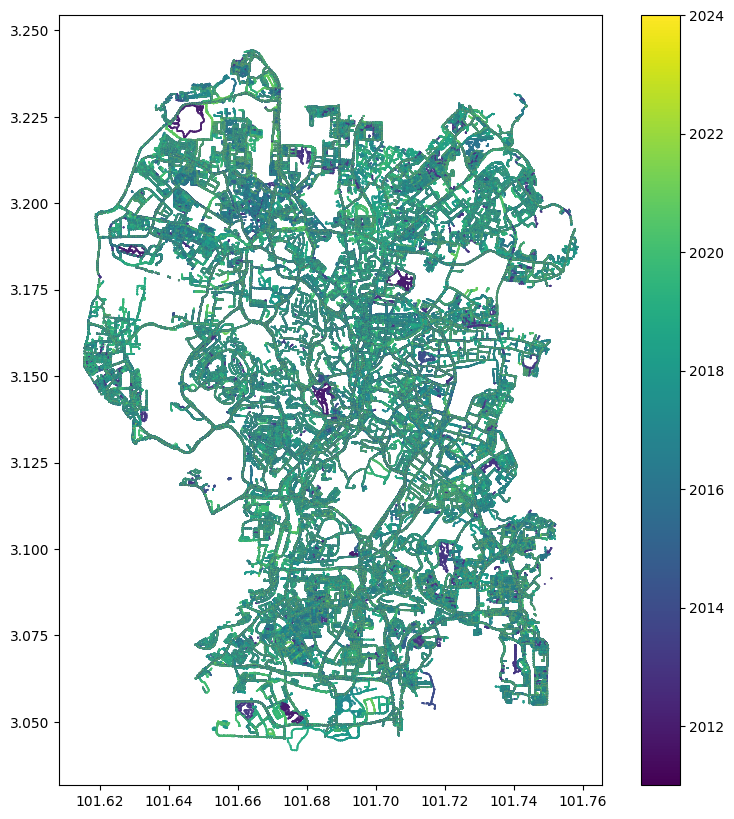

In [10]:
gdf.plot(figsize = (10,10), 
         column = 'year', 
         markersize = 0.1, 
         legend = True)

# 3. label the Panoid Selectively for reducing data download size (continue in 01b_download2.ipynb)

# 4.Download images

In [ ]:
line = """python ./Request_GSV_images_pl.py --city={cityabbr}"""
cityls = [city for city, v in city_pano_size.items() if v>5000]
todo = city_meta.index
for i in range(1, len(cityls), 3):
    print(i)
    with open(f'./downloadGSV/gsv_img_download_{i}.sh', 'w') as the_file:
        for city in cityls[i:i+3]:
            cityabbr = city.lower().replace(" ", "")
            the_file.write(
                line.format(cityabbr = cityabbr)+'\n'
            )

1
4
7
10


In [10]:
# Send these cities to ai-research for batch downloading
to_transfer = [
    # 'kualalumpur','toronto','nagoya', 'milan', 'riodejaneiro', 'jakarta', 'lima', 'metromanila'
    'bangkok'
]
for city in to_transfer:
    cityabbr = city.replace(" ", "").lower()
    dirsave = f'{GSVROOT}/{cityabbr}'
    rsyncline = """
    rsync -aP {dirsave} yuanzf@ai-research:/group/geog_pyloo/08_GSV/data/gsv_rgb/
    """.format(dirsave = dirsave)
    print(rsyncline) # IlmfaMf100y


    rsync -aP /lustre1/g/geog_pyloo/05_timemachine/GSV/gsv_rgb/bangkok yuanzf@ai-research:/group/geog_pyloo/08_GSV/data/gsv_rgb/
    


In [15]:
pointDF = pd.read_pickle(os.path.join(dirsave,'sentPt.p'))
pointDF.head()

,geometry,newID,lat,lon,id
0,POINT (-70.75601 41.96089),8826674_0,41.960888,-70.756013,0
1,POINT (-70.75606 41.96110),8826674_1,41.961097,-70.756059,1
2,POINT (-70.75580 41.96078),1127937227_2,41.960777,-70.755805,2
3,POINT (-70.75531 41.96069),1127937227_2,41.960693,-70.755310,3
4,POINT (-70.71657 41.96705),8826704_3,41.967052,-70.716567,4


In [50]:
imgGDF2['id'] = imgGDF2['id'].astype(float).astype(int)

In [52]:
pointDF = pointDF[~pointDF['id'].isin(finished['id'])].reset_index(drop=True)
pointDF.shape

(2790970, 5)

In [51]:
finished = pd.read_csv(os.path.join(dirsave+"_2",'gsv_pano.csv'))


In [16]:
# check the panoid's distribution by h3 index
import h3
res = 9
imgGDF[f'h3_{res}'] = imgGDF.apply(lambda x: h3.geo_to_h3(x.lat, x.lon, 9), axis=1)
summary = imgGDF.groupby([f'h3_{res}', 'year']).size().reset_index(name='counts')
summary.head()

TypeError: must be real number, not str

In [79]:
# group the years by every 3 years
imgGDF['year_group'] = imgGDF['year'].apply(lambda x: int(x/3)*3)
imgGDF['year_group'].nunique()

5

In [88]:
# summary['counts'].describe()
# each h3 index we sample 10 image per year, if the population is less than 10, we sample all
imgGDF_sample = imgGDF.groupby([f'h3_{res}', 'year_group']).apply(lambda x: x.sample(10) if len(x)>10 else x)\
    .reset_index(drop = True)
imgGDF_sample.shape

(834288, 8)

In [95]:
imgGDF_sample.to_pickle(os.path.join(dirsave,'gsv_pano_sampled.p'))

# 2. Check progress of all

# 2. Write a script to tar archive data and transfer to hpc

In [2]:
import os
text = """
cd 08_GSV/data/gsv_rgb
tar -czvf {city}.tar.gz ./{city}
rsync -azP {city}.tar.gz yuanzf@hpc2021.hku.hk:/lustre1/g/geog_pyloo/05_timemachine/GSV/gsv_rgb/
rm {city}.tar.gz
"""
folder = "/group/geog_pyloo/08_GSV/data/gsv_rgb"
cities = os.listdir(folder)
skip = ['virginia_random', 'bogota.tar.gz', '.DS_Store', 'bogotá', 'taipei', 'accra']
cities = [x for x in cities if x not in skip]
len(cities)
with open("tar.sh", "w") as f:
    for city in cities:
        print(text.format(city = city))
        f.write(text.format(city = city))


cd 08_GSV/data/gsv_rgb
tar -czvf saopaulo.tar.gz ./saopaulo
rsync -azP saopaulo.tar.gz yuanzf@hpc2021.hku.hk:/lustre1/g/geog_pyloo/05_timemachine/GSV/gsv_rgb/
rm saopaulo.tar.gz


cd 08_GSV/data/gsv_rgb
tar -czvf hongkong.tar.gz ./hongkong
rsync -azP hongkong.tar.gz yuanzf@hpc2021.hku.hk:/lustre1/g/geog_pyloo/05_timemachine/GSV/gsv_rgb/
rm hongkong.tar.gz


cd 08_GSV/data/gsv_rgb
tar -czvf london.tar.gz ./london
rsync -azP london.tar.gz yuanzf@hpc2021.hku.hk:/lustre1/g/geog_pyloo/05_timemachine/GSV/gsv_rgb/
rm london.tar.gz


cd 08_GSV/data/gsv_rgb
tar -czvf boston.tar.gz ./boston
rsync -azP boston.tar.gz yuanzf@hpc2021.hku.hk:/lustre1/g/geog_pyloo/05_timemachine/GSV/gsv_rgb/
rm boston.tar.gz


cd 08_GSV/data/gsv_rgb
tar -czvf chicago.tar.gz ./chicago
rsync -azP chicago.tar.gz yuanzf@hpc2021.hku.hk:/lustre1/g/geog_pyloo/05_timemachine/GSV/gsv_rgb/
rm chicago.tar.gz


cd 08_GSV/data/gsv_rgb
tar -czvf worcester.tar.gz ./worcester
rsync -azP worcester.tar.gz yuanzf@hpc2021.hku.hk:/lustre

# 2. Load the image

def tiles_info(panoid):
    """
    Generate a list of a panorama's tiles and their position.

    The format is (x, y, filename, fileurl)
    """

    image_url = "http://cbk0.google.com/cbk?output=tile&panoid={0:}&zoom=5&x={1:}&y={2:}"

    # The tiles positions
    coord = list(itertools.product(range(26),range(13)))

    tiles = [(x, y, "%s_%dx%d.jpg" % (panoid, x, y), image_url.format(panoid, x, y)) for x,y in coord]

    return tiles